### Dataset preparation

In [1]:
### Load necessary modules -------------------------------
# interactive plotting
#%matplotlib inline
#%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Machine learning libraries
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer

# Other
from mltools import classification_tools as CT
from mltools import model_tools as MT

In [2]:
df = pd.read_csv('fico.csv')
# Pasar la variable RiskPerformance a int64
df['RiskPerformance'] = df['RiskPerformance'].astype('int64')
# Put the column RiskPerformance as a category
df['RiskPerformance'] = df['RiskPerformance'].astype('category')
# Change RiskPerformance values, if they are 1 to True and if they are 0 to False
df['RiskPerformance'] = df['RiskPerformance'].replace({1: 'Yes', 0: 'No'})
df.dropna(inplace=True)
# Drop the column called NumTotalTrades
#df.drop(columns='NumTotalTrades', inplace=True)

In [3]:
# Define input and output matrices
INPUTS = ['ExternalRiskEstimate', 'NetFractionRevolvingBurden',
       'AverageMInFile', 'MSinceOldestTradeOpen', 'PercentTradesWBalance',
       'PercentInstallTrades', 'NumSatisfactoryTrades', "NumTotalTrades",
       'PercentTradesNeverDelq', 'MSinceMostRecentInqexcl7days']
OUTPUT = 'RiskPerformance'

X = df[INPUTS]
Y = df[OUTPUT]

# Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.2,  #percentage of test data
                                                    random_state=2023, #seed for replication
                                                    stratify = Y)   #Preserves distribution of y. Same proportion. useful for classification but not for regression problemas

## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['RiskPerformance'] = Y_train # We will call Y as output variable for simplicity
dfTS_eval = X_test.copy()
dfTS_eval['RiskPerformance'] = Y_test # We will call Y as output variable for simplicity

### Decision Tree model

In [4]:
#-------------------------------------------------------------------------------------------------
#---------------------------- DECISION TREE MODEL ------------------------------------------------
#-------------------------------------------------------------------------------------------------
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_DT = INPUTS

param = {'DT__min_impurity_decrease': np.arange(0,0.01,0.0002)} # Minimum entropy to decrease in each split. Prueba un modelo con cada parámetro. 
# Podríamos añaadir aqui los parametros de pipeline para probar con cada uno de ellos.
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('DT', DecisionTreeClassifier(criterion='gini',  # impuriry measure
                                                     min_samples_split=5, # Minimum number of obs in node to keep cutting. Si subo, 
                                                     # se reduce el overfitting ya que no le dejo seguir creando hojas.
                                                     min_samples_leaf=10, # Minimum number of obs in a terminal node. Significa que en cada hoja final, para poder clasificar,
                                                     # tiene que haber un mínimo de 5 observaciones. Si subo este número, se reduce el overfitting.
                                                     random_state=2023))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
tree_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
tree_fit.fit(X_train[INPUTS_DT], Y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('DT',
                                        DecisionTreeClassifier(min_samples_leaf=10,
                                                               min_samples_split=5,
                                                               random_state=2023))]),
             n_jobs=-1,
             param_grid={'DT__min_impurity_decrease': array([0.    , 0.0002, 0.0004, 0.0006, 0.0008, 0.001 , 0.0012, 0.0014,
       0.0016, 0.0018, 0.002 , 0.0022, 0.0024, 0.0026, 0.0028, 0.003 ,
       0.0032, 0.0034, 0.0036, 0.0038, 0.004 , 0.0042, 0.0044, 0.0046,
       0.0048, 0.005 , 0.0052, 0.0054, 0.0056, 0.0058, 0.006 , 0.0062,
       0.0064, 0.0066, 0.0068, 0.007 , 0.0072, 0.0074, 0.0076, 0.0078,
       0.008 , 0.0082, 0.0084, 0.0086, 0.0088, 0.009 , 0.0092, 0.0094,
       0.0096, 0.0098])},
             scoring='accuracy')

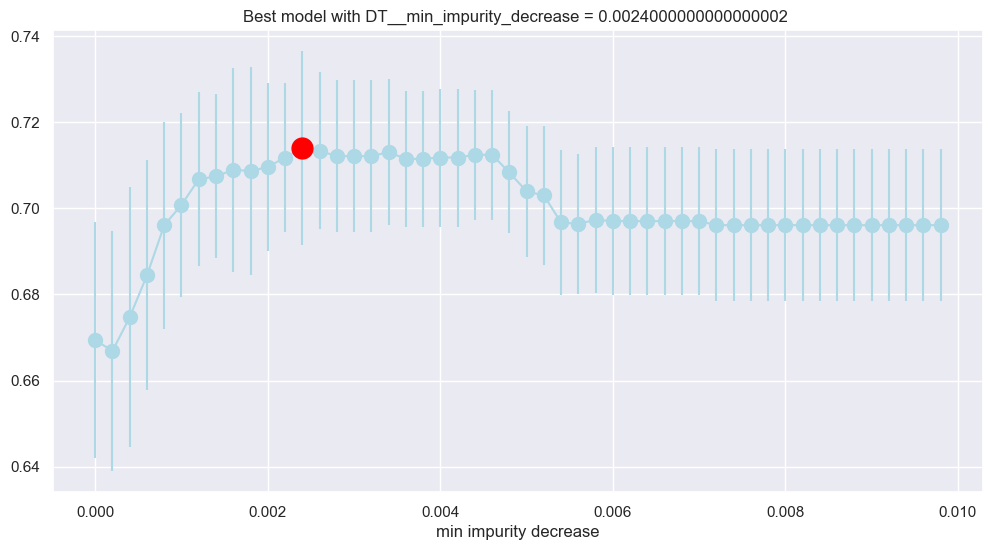

In [5]:
MT.plotModelGridError(tree_fit)

In [6]:
# Obtain Cross-Validation score
print("CV accuracy is")
cross_val_score(tree_fit, X_train[INPUTS_DT], Y_train, cv=10, scoring='accuracy').mean()

CV accuracy is


0.7127570434336862

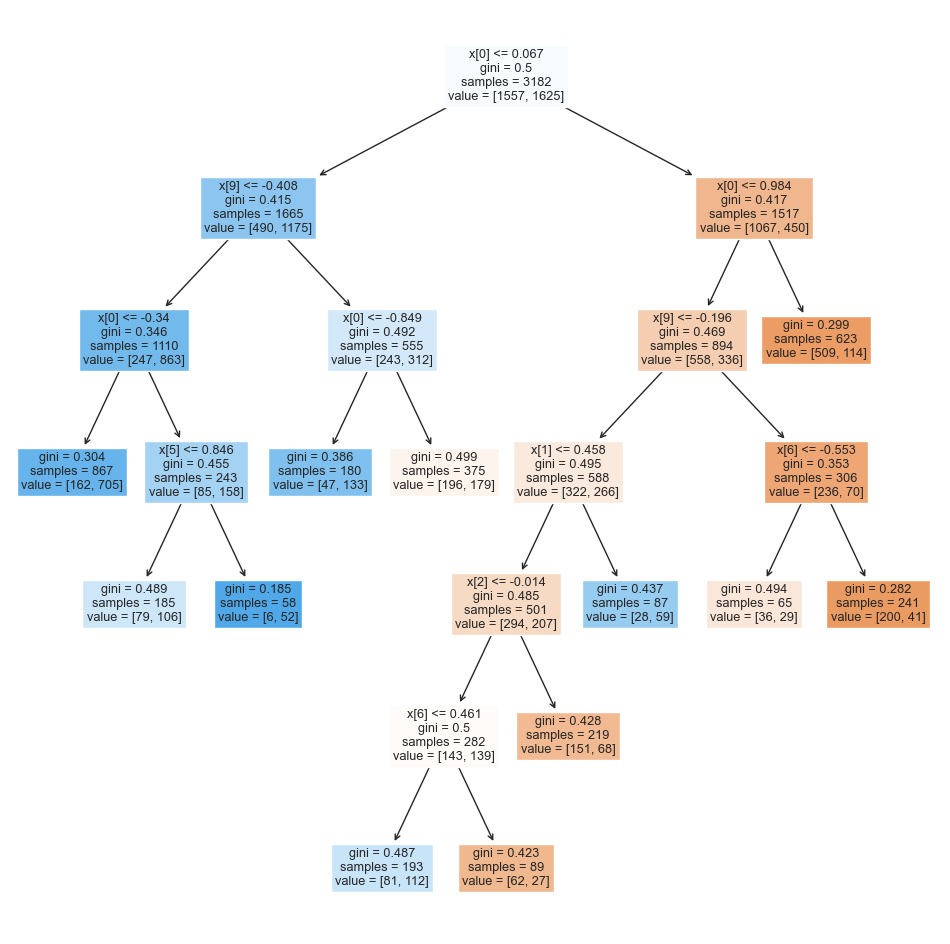

In [32]:
## Plot the decision tree model
plt.figure(figsize=(12, 12))
plot_tree(tree_fit.best_estimator_['DT'], filled=True)
plt.show()

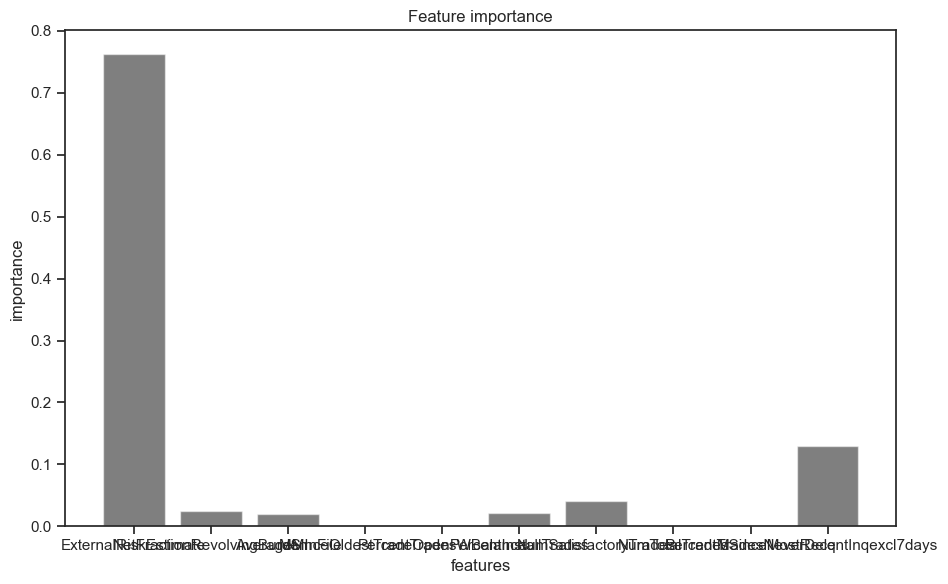

In [33]:
## Plot the variable importance of each feature
plt.figure(figsize=(6 * 1.618, 6))
index = np.arange(len(X_train[INPUTS_DT].columns))
bar_width = 0.35
plt.bar(index, tree_fit.best_estimator_['DT'].feature_importances_, color='black', alpha=0.5)
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature importance')
plt.xticks(index, X_train[INPUTS_DT].columns)
plt.tight_layout()
plt.show()

In [34]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_DT_pred'] = tree_fit.predict(X_train[INPUTS_DT])
dfTR_eval['Y_DT_prob_neg'] = tree_fit.predict_proba(X_train[INPUTS_DT])[:,0]
dfTR_eval['Y_DT_prob_pos'] = tree_fit.predict_proba(X_train[INPUTS_DT])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_DT_pred'] = tree_fit.predict(X_test[INPUTS_DT])
dfTS_eval['Y_DT_prob_neg'] = tree_fit.predict_proba(X_test[INPUTS_DT])[:,0]
dfTS_eval['Y_DT_prob_pos'] = tree_fit.predict_proba(X_test[INPUTS_DT])[:,1]

#visualize evaluated data
dfTR_eval.head()

,ExternalRiskEstimate,NetFractionRevolvingBurden,AverageMInFile,MSinceOldestTradeOpen,PercentTradesWBalance,PercentInstallTrades,NumSatisfactoryTrades,NumTotalTrades,PercentTradesNeverDelq,MSinceMostRecentInqexcl7days,RiskPerformance,Y_DT_pred,Y_DT_prob_neg,Y_DT_prob_pos
1605,83.0,0.0,50.0,157.0,20.0,53.0,13.0,15.0,93.0,3.0,No,No,0.817014,0.182986
524,81.0,34.0,75.0,183.0,40.0,44.0,45.0,45.0,100.0,0.0,No,No,0.696629,0.303371
2994,68.0,25.0,34.0,81.0,65.0,32.0,25.0,25.0,100.0,2.0,No,No,0.522667,0.477333
103,60.0,35.0,25.0,49.0,72.0,32.0,24.0,25.0,100.0,0.0,Yes,Yes,0.186851,0.813149
4112,59.0,78.0,52.0,147.0,100.0,71.0,5.0,7.0,86.0,12.0,Yes,Yes,0.261111,0.738889


In [35]:
CT.confusion_matrix(dfTR_eval['RiskPerformance'], dfTR_eval['Y_DT_pred'], labels=['No','Yes'])
# No information rate, es el porcentaje de aciertos que tendríamos si siempre predijeramos la clase mayoritaria.

Confusion Matrix and Statistics
	   Prediction
Reference   No  Yes
       No 1154  403
      Yes  458 1167

Accuracy: 0.73
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.46
Mcnemar's Test P-Value: 0.07
Sensitivity: 0.72
Specificity: 0.74
Precision: 0.72
Recall: 0.74
Prevalence: 0.51
Detection Rate: 0.37
Detection prevalence: 0.49
Balanced accuracy: 0.73
F1 Score: 0.73
Positive label: No


In [36]:
CT.confusion_matrix(dfTS_eval['RiskPerformance'], dfTS_eval['Y_DT_pred'], labels=['No','Yes'])

Confusion Matrix and Statistics
	   Prediction
Reference  No  Yes
       No 279  111
      Yes 120  286

Accuracy: 0.71
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.42
Mcnemar's Test P-Value: 0.6
Sensitivity: 0.7
Specificity: 0.72
Precision: 0.7
Recall: 0.72
Prevalence: 0.51
Detection Rate: 0.36
Detection prevalence: 0.5
Balanced accuracy: 0.71
F1 Score: 0.71
Positive label: No


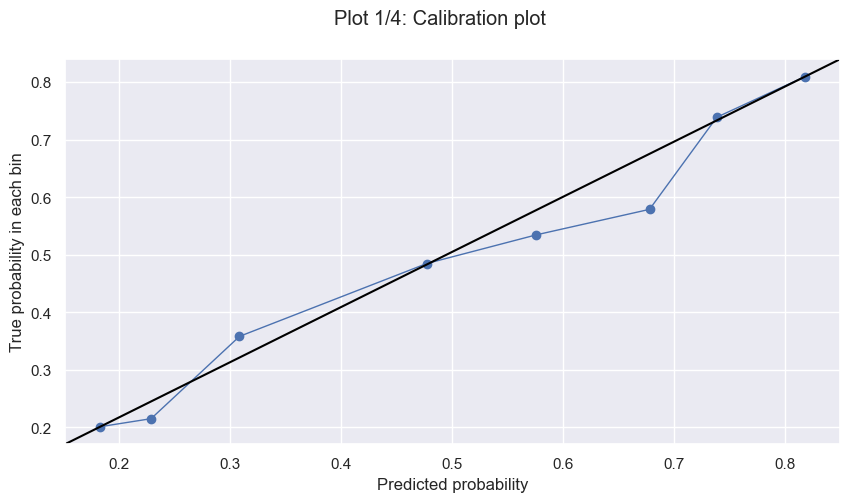

c:\Users\pablo\anaconda3\envs\ML\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


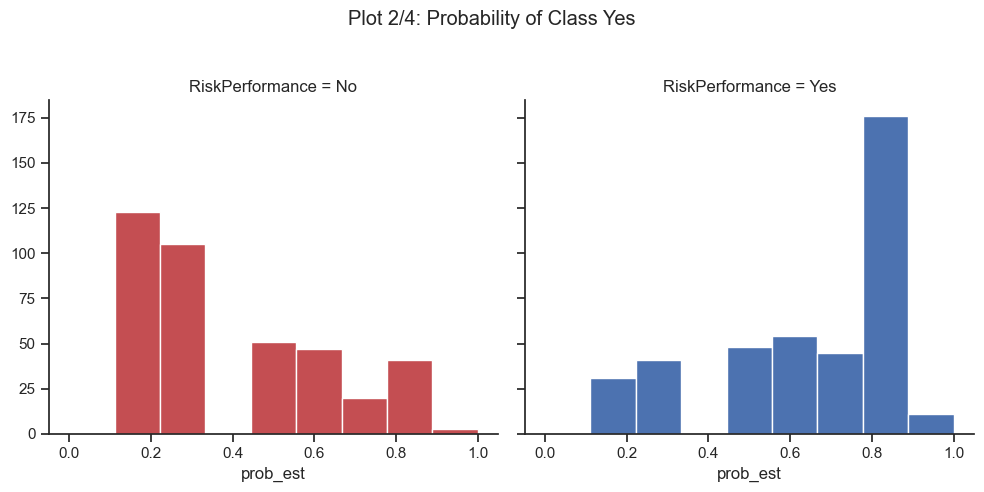

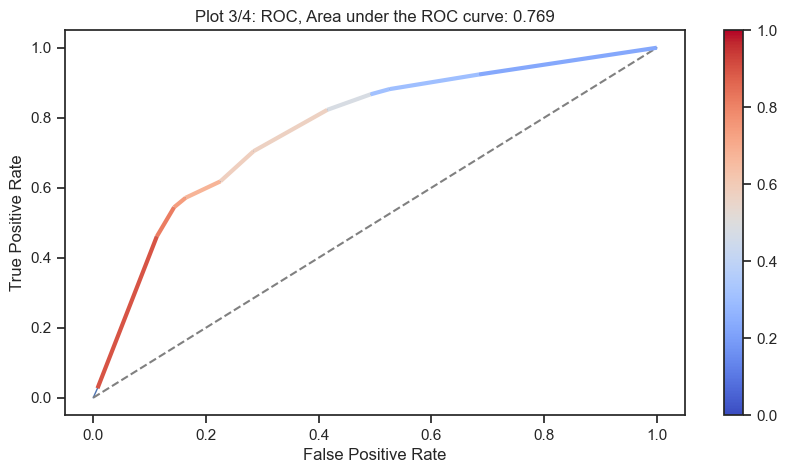

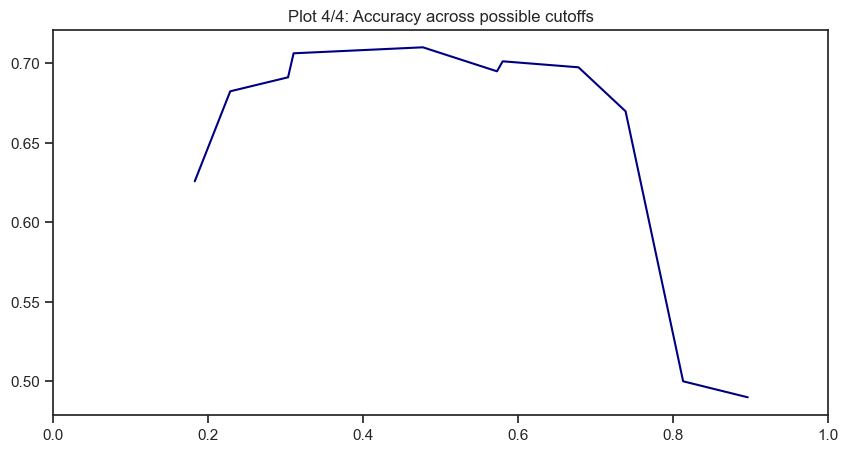

In [11]:
CT.plotClassPerformance(dfTS_eval['RiskPerformance'], tree_fit.predict_proba(X_test[INPUTS_DT]), selClass='Yes')

### Random Forest

In [7]:
INPUTS = ['ExternalRiskEstimate', 'NetFractionRevolvingBurden',
       'AverageMInFile', 'PercentTradesWBalance',
       'PercentInstallTrades', "NumTotalTrades",
       'PercentTradesNeverDelq', 'MSinceMostRecentInqexcl7days']
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_RF = INPUTS
# Define input and output matrices

param = {'RF__n_estimators': range(10, 400, 15)} #Number of trees to grow
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('RF', RandomForestClassifier(criterion='gini', # impuriry measure
                                                    max_features=len(X_train.columns),  # number of variables randomly sampled as candidates at each split.
                                                    min_samples_split=5,  # Minimum number of obs in node to keep cutting
                                                    min_samples_leaf=10, # Minimum number of obs in a terminal node
                                                    random_state=2023))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 8
rf_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
rf_fit.fit(X_train[INPUTS_RF], Y_train) # Search in grid

GridSearchCV(cv=8,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('RF',
                                        RandomForestClassifier(max_features=10,
                                                               min_samples_leaf=10,
                                                               min_samples_split=5,
                                                               random_state=2023))]),
             n_jobs=-1, param_grid={'RF__n_estimators': range(10, 400, 15)},
             scoring='accuracy')

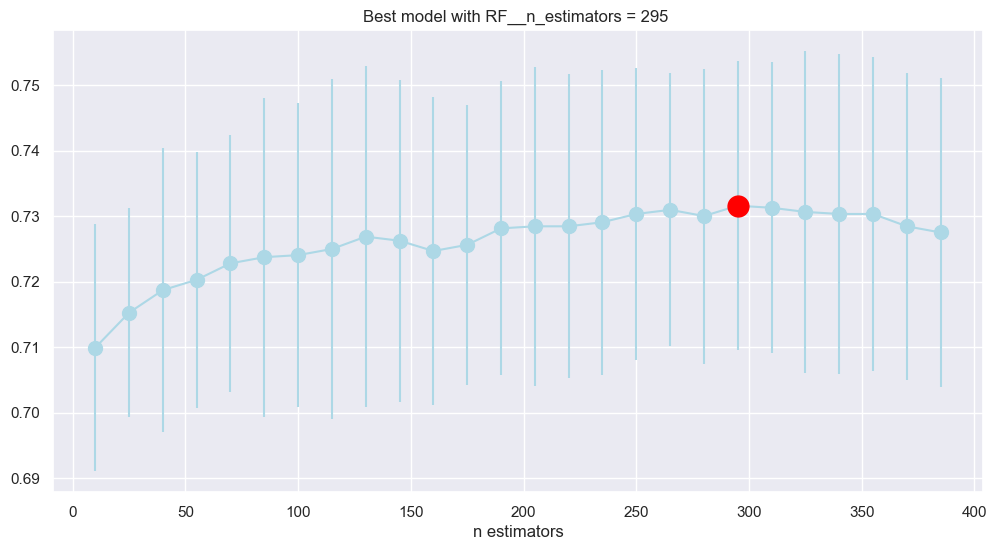

In [8]:
MT.plotModelGridError(rf_fit)

In [9]:
# Obtain Cross-Validation score
print("CV accuracy is")
cross_val_score(rf_fit, X_train[INPUTS_RF], Y_train, cv=10, scoring='accuracy').mean()

CV accuracy is


0.7265846493562822

ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of labels (10).

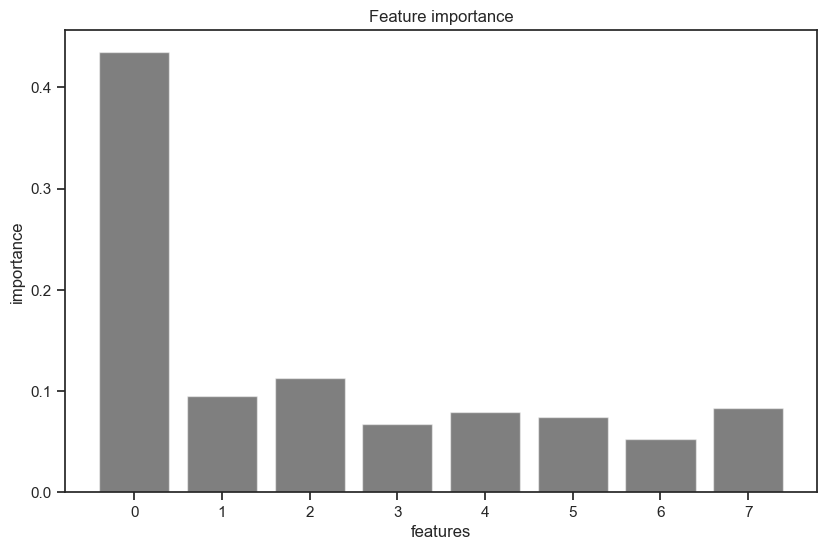

In [51]:
## Plot the variable importance of each feature
plt.figure(figsize=(6 * 1.618, 6))
index = np.arange(len(X_train[INPUTS_RF].columns))
bar_width = 0.35
plt.bar(index, rf_fit.best_estimator_['RF'].feature_importances_, color='black', alpha=0.5)
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature importance')
plt.xticks(index, X_train.columns)
plt.tight_layout()
plt.show()

In [52]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_RF_pred'] = rf_fit.predict(X_train[INPUTS_RF])
dfTR_eval['Y_RF_prob_neg'] = rf_fit.predict_proba(X_train[INPUTS_RF])[:,0]
dfTR_eval['Y_RF_prob_pos'] = rf_fit.predict_proba(X_train[INPUTS_RF])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_RF_pred'] = rf_fit.predict(X_test[INPUTS_RF])
dfTS_eval['Y_RF_prob_neg'] = rf_fit.predict_proba(X_test[INPUTS_RF])[:,0]
dfTS_eval['Y_RF_prob_pos'] = rf_fit.predict_proba(X_test[INPUTS_RF])[:,1]

dfTR_eval.head()

,ExternalRiskEstimate,NetFractionRevolvingBurden,AverageMInFile,MSinceOldestTradeOpen,PercentTradesWBalance,PercentInstallTrades,NumSatisfactoryTrades,NumTotalTrades,PercentTradesNeverDelq,MSinceMostRecentInqexcl7days,RiskPerformance,Y_DT_pred,Y_DT_prob_neg,Y_DT_prob_pos,Y_RF_pred,Y_RF_prob_neg,Y_RF_prob_pos
1605,83.0,0.0,50.0,157.0,20.0,53.0,13.0,15.0,93.0,3.0,No,No,0.817014,0.182986,No,0.657327,0.342673
524,81.0,34.0,75.0,183.0,40.0,44.0,45.0,45.0,100.0,0.0,No,No,0.696629,0.303371,No,0.781346,0.218654
2994,68.0,25.0,34.0,81.0,65.0,32.0,25.0,25.0,100.0,2.0,No,No,0.522667,0.477333,No,0.642652,0.357348
103,60.0,35.0,25.0,49.0,72.0,32.0,24.0,25.0,100.0,0.0,Yes,Yes,0.186851,0.813149,Yes,0.140896,0.859104
4112,59.0,78.0,52.0,147.0,100.0,71.0,5.0,7.0,86.0,12.0,Yes,Yes,0.261111,0.738889,Yes,0.090631,0.909369


In [53]:
CT.confusion_matrix(dfTR_eval['RiskPerformance'], dfTR_eval['Y_RF_pred'], labels=['No','Yes'])

Confusion Matrix and Statistics
	   Prediction
Reference   No  Yes
       No 1245  312
      Yes  262 1363

Accuracy: 0.82
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.64
Mcnemar's Test P-Value: 0.04
Sensitivity: 0.84
Specificity: 0.8
Precision: 0.83
Recall: 0.8
Prevalence: 0.51
Detection Rate: 0.43
Detection prevalence: 0.53
Balanced accuracy: 0.82
F1 Score: 0.81
Positive label: No


In [54]:
CT.confusion_matrix(dfTS_eval['RiskPerformance'], dfTS_eval['Y_RF_pred'], labels=['No','Yes'])

Confusion Matrix and Statistics
	   Prediction
Reference  No  Yes
       No 290  100
      Yes 103  303

Accuracy: 0.74
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.49
Mcnemar's Test P-Value: 0.89
Sensitivity: 0.75
Specificity: 0.74
Precision: 0.74
Recall: 0.74
Prevalence: 0.51
Detection Rate: 0.38
Detection prevalence: 0.51
Balanced accuracy: 0.74
F1 Score: 0.74
Positive label: No


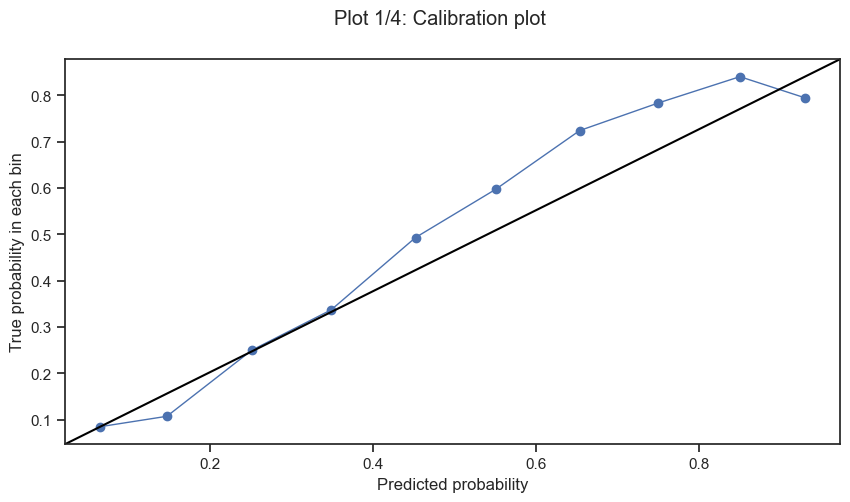

c:\Users\pablo\anaconda3\envs\ML\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


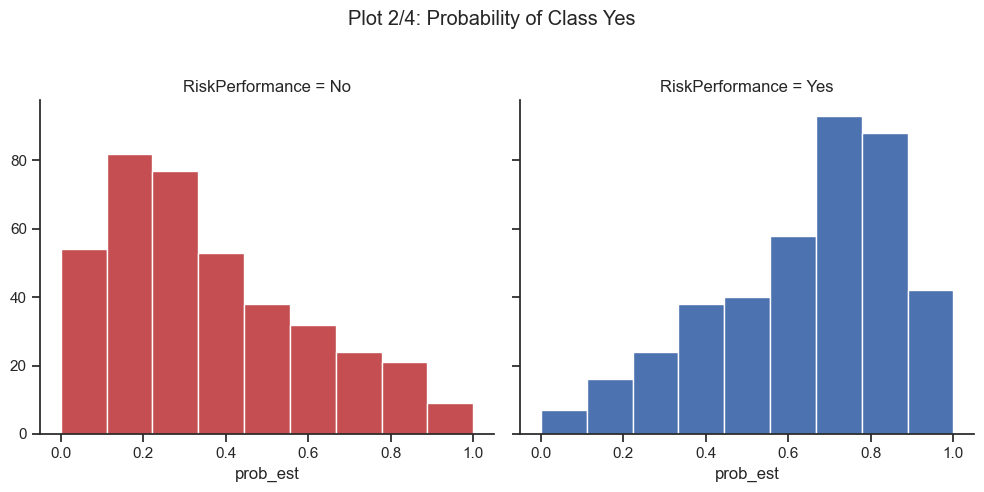

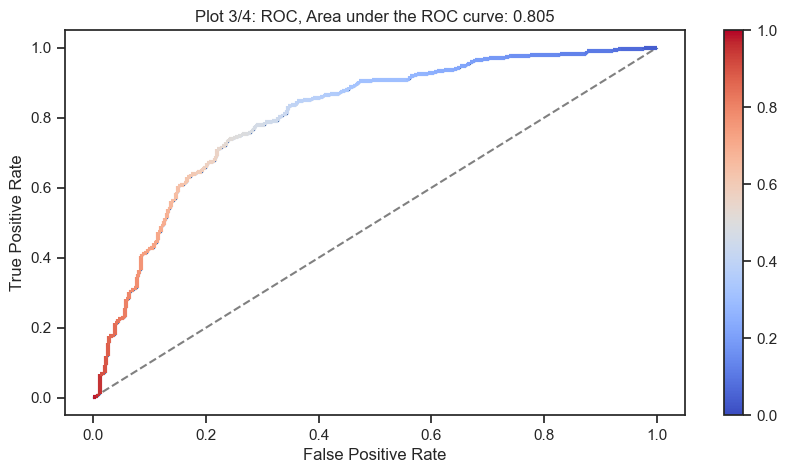

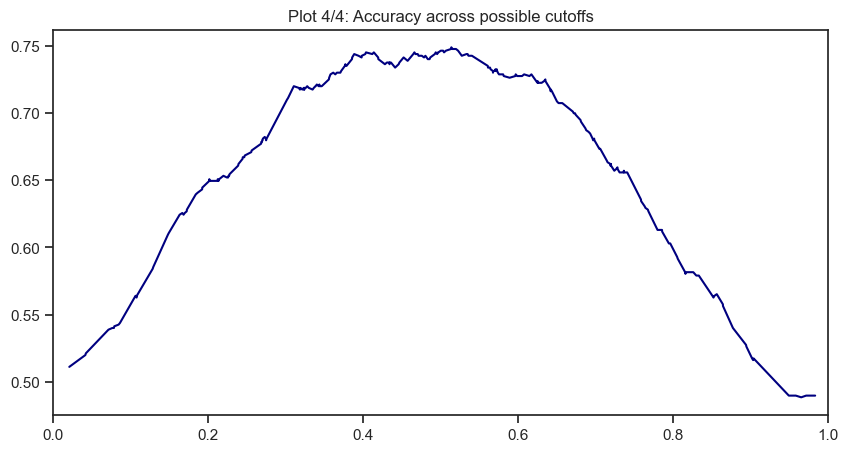

In [55]:
CT.plotClassPerformance(dfTS_eval['RiskPerformance'], rf_fit.predict_proba(X_test[INPUTS_RF]), selClass='Yes')

## Comparing tree-based models

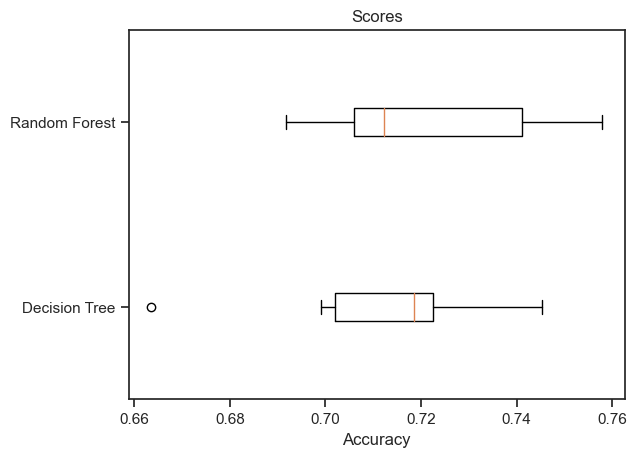

In [47]:
## Compare models
metric = 'Accuracy'
score = {'Decision Tree': cross_val_score(tree_fit, X_train[INPUTS_DT], Y_train, cv=10, scoring='accuracy'), 
         'Random Forest': cross_val_score(rf_fit, X_train[INPUTS_RF], Y_train, cv=10, scoring='accuracy') }
MT.dotplot(score, metric)

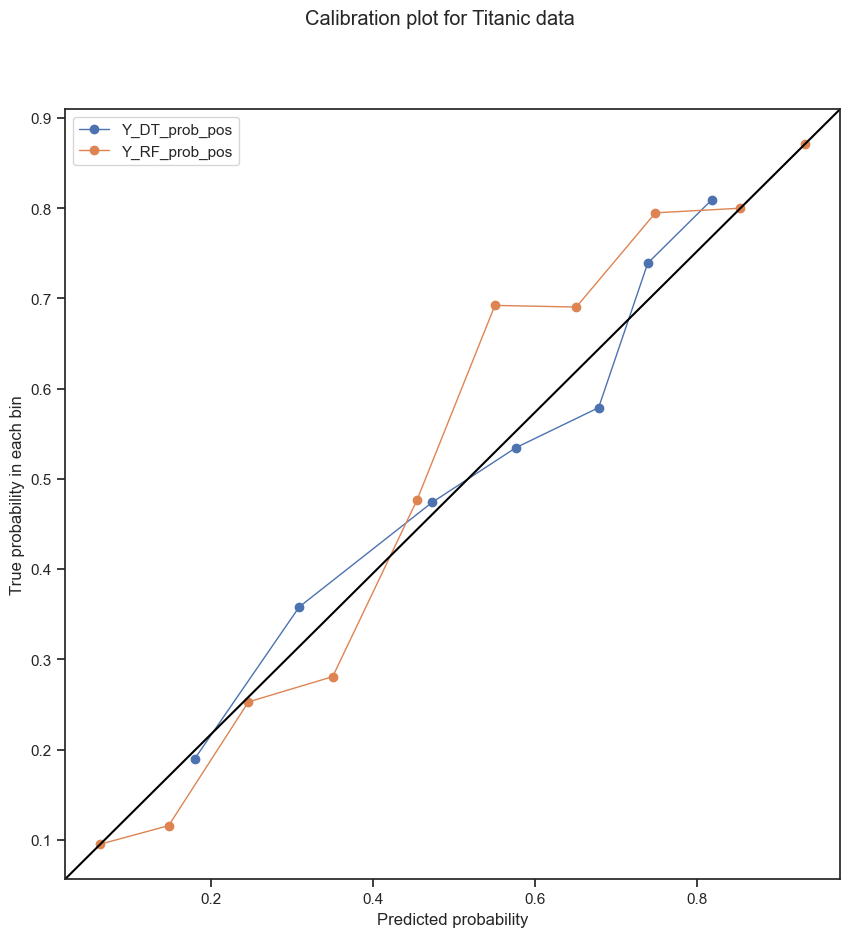

In [48]:
CT.calibration_plot(Y_test, dfTS_eval[['Y_DT_prob_pos','Y_RF_prob_pos']])